In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, log_loss, accuracy_score, f1_score, hamming_loss
import torch
import textwrap


seed = 1234
np.random.seed(seed)
torch.manual_seed(seed);

# Saves all plots as images. Need to create img/ folder in root directory for this to work properly
# 1: Save images when run
# 0: Do not save images
SAVE_PLOTS_AS_IMAGES = 1

# Data Preprocessing

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

In [ ]:
labels = test_labels.columns[1:]
X, y = train['comment_text'], train[labels].values

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1, random_state=seed, shuffle=True)
X_te, y_te = test['comment_text'], test_labels[labels]

mask = (y_te != -1).any(axis=1)

# Filter out test labels with values of -1
X_te_fltr = X_te[mask]
y_te_fltr = y_te[mask]

In [ ]:
# Vectorize text
vectorizer = CountVectorizer(max_features=10000, stop_words='english')
X_tr_trans = vectorizer.fit_transform(X_tr)
X_val_trans = vectorizer.transform(X_val)
X_te_trans = vectorizer.transform(X_te)
X_te_trans_fltr = vectorizer.transform(X_te_fltr)

# Logistic Regression

In [ ]:
clf = LogisticRegression(max_iter=2000,
                         class_weight='balanced',
                         random_state=seed,
                         C=0.5,
                        )
clf.fit(X_tr_trans, y_tr[:, 0])


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.5
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,1234
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [ ]:
y_pred_val = clf.predict_proba(X_val_trans)[:, 1]
y_pred = clf.predict(X_te_trans)
y_prob = clf.predict_proba(X_te_trans)[:,1]
y_prob_fltr = clf.predict_proba(X_te_trans_fltr)[:, 1]
print(y_pred_val.shape)
print(y_prob.shape)
print(y_te['toxic'].shape)

(15958,)
(153164,)
(153164,)


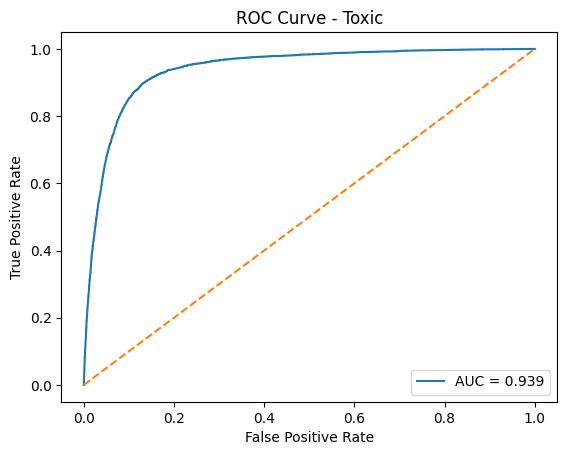

In [ ]:
fpr, tpr, _ = roc_curve(y_te_fltr['toxic'], y_prob_fltr)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Toxic")
plt.legend()
if SAVE_PLOTS_AS_IMAGES:
    plt.savefig('img/log_reg_roc.png')
plt.show()

In [ ]:
C_values = [0.01, 0.1, 0.5, 1, 5, 10, 50]
train_loss = []
val_loss = []

for C in C_values:
    clf = LogisticRegression(max_iter=2000,
                             class_weight='balanced',
                             C=C,
                             random_state=42)
    clf.fit(X_tr_trans, y_tr[:,0])

    y_train_prob = clf.predict_proba(X_tr_trans)[:,1]
    y_val_prob = clf.predict_proba(X_val_trans)[:,1]

    train_loss.append(log_loss(y_tr[:,0], y_train_prob))
    val_loss.append(log_loss(y_val[:,0], y_val_prob))

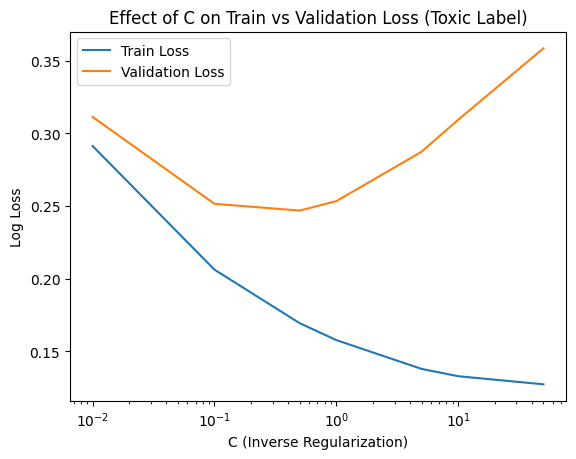

C=0.01, loss=0.3112982596755114
C=0.1, loss=0.25149847690092303
C=0.5, loss=0.24683528392157164
C=1, loss=0.2533195800749995
C=5, loss=0.287343362383649
C=10, loss=0.30939588823029257
C=50, loss=0.35852427667888054

=== SUMMARY ===
min loss: 0.24683528392157164
Best C val: 0.5



In [ ]:
plt.semilogx(C_values, train_loss, label='Train Loss')
plt.semilogx(C_values, val_loss, label='Validation Loss')
plt.xlabel('C (Inverse Regularization)')
plt.ylabel('Log Loss')
plt.title('Effect of C on Train vs Validation Loss (Toxic Label)')
plt.legend()
if SAVE_PLOTS_AS_IMAGES:
    plt.savefig('img/log_reg_c_loss_curve.png')
plt.show()

min_loss = float('inf')
min_C = -1
for C, loss in zip(C_values, val_loss):
    print(f'C={C}, loss={loss}')
    if loss < min_loss:
        min_C = C
        min_loss = loss
print(f'''
=== SUMMARY ===
min loss: {min_loss}
Best C val: {min_C}
''')

In [ ]:
subset_fraction = 0.2  # 20% of data
n_subset = int(X_tr_trans.shape[0] * subset_fraction)

X_tr_small = X_tr_trans[:n_subset]
y_tr_small = y_tr[:n_subset]

C_values = [0.01, 0.1, 0.5, 1, 5, 10, 50]
train_loss = []
val_loss = []

for C in C_values:
    # Wrap Logistic Regression in OneVsRest for multi-label classification
    clf = OneVsRestClassifier(LogisticRegression(max_iter=2000,
                                                 class_weight='balanced',
                                                 C=C,
                                                 random_state=42))
    clf.fit(X_tr_small, y_tr_small)  # Train on all labels at once

    # Predict probabilities for all labels
    y_train_prob = clf.predict_proba(X_tr_small)  # shape: (n_samples, n_labels)
    y_val_prob = clf.predict_proba(X_val_trans)

    # Compute log loss for each label and take the average
    train_losses_per_label = [log_loss(y_tr_small[:, i], y_train_prob[:, i]) for i in range(y_tr.shape[1])]
    val_losses_per_label = [log_loss(y_val[:, i], y_val_prob[:, i]) for i in range(y_tr.shape[1])]

    train_loss.append(np.mean(train_losses_per_label))
    val_loss.append(np.mean(val_losses_per_label))

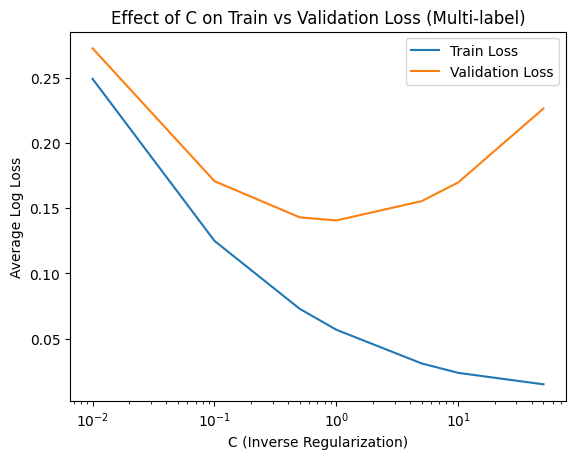

C=0.01, loss=0.2724368490737171
C=0.1, loss=0.1706975626867574
C=0.5, loss=0.14296011048264062
C=1, loss=0.14060386069033237
C=5, loss=0.15537258252861993
C=10, loss=0.1697485805468928
C=50, loss=0.22633201930837177

=== SUMMARY ===
min loss: 0.14060386069033237
Best C val: 1



In [ ]:
plt.semilogx(C_values, train_loss, label='Train Loss')
plt.semilogx(C_values, val_loss, label='Validation Loss')
plt.xlabel('C (Inverse Regularization)')
plt.ylabel('Average Log Loss')
plt.title('Effect of C on Train vs Validation Loss (Multi-label)')
plt.legend()
if 'SAVE_PLOTS_AS_IMAGES' in globals() and SAVE_PLOTS_AS_IMAGES:
    plt.savefig('img/log_reg_c_loss_curve_multi_label.png')
plt.show()

min_loss = float('inf')
min_C = -1
for C, loss in zip(C_values, val_loss):
    print(f'C={C}, loss={loss}')
    if loss < min_loss:
        min_C = C
        min_loss = loss
print(f'''
=== SUMMARY ===
min loss: {min_loss}
Best C val: {min_C}
''')

In [ ]:
# From here onwards, the best C value from our dataset will be assumed to be C=C_best.
C_best = 1

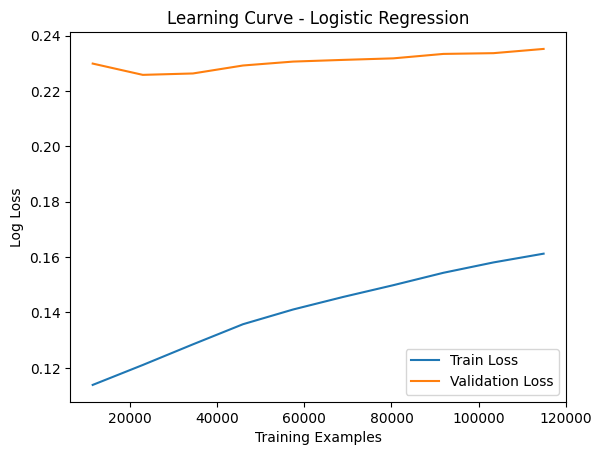

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

clf = LogisticRegression(max_iter=2000,
                         class_weight='balanced',
                         C=C_best,
                         random_state=seed)

train_sizes, train_scores, test_scores = learning_curve(
    clf, X_tr_trans, y_tr[:,0],
    cv=5,
    scoring="neg_log_loss",    # logistic regression loss
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# convert negative log loss back to positive
train_loss = -np.mean(train_scores, axis=1)
val_loss = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_loss, label="Train Loss")
plt.plot(train_sizes, val_loss, label="Validation Loss")
plt.xlabel("Training Examples")
plt.ylabel("Log Loss")
plt.title("Learning Curve - Logistic Regression")
plt.legend()
if SAVE_PLOTS_AS_IMAGES:
    plt.savefig('img/learning_curves.png')
plt.show()

In [ ]:
# Train OneVsRest Logistic Regression on all labels
clf = OneVsRestClassifier(LogisticRegression(max_iter=2000,
                                             class_weight='balanced',
                                             C=C_best,
                                             random_state=seed),
                                             n_jobs=-1)
clf.fit(X_tr_trans, y_tr)


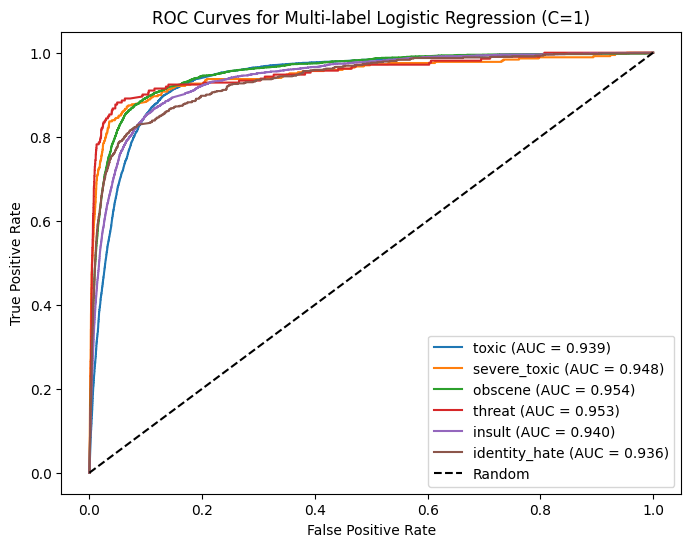

In [ ]:
y_prob = clf.predict_proba(X_te_trans_fltr)

plt.figure(figsize=(8,6))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_te_fltr[label], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')

plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-label Logistic Regression (C=1)')
plt.legend(loc='lower right')
# plt.grid(True)
if SAVE_PLOTS_AS_IMAGES:
    plt.savefig('img/log_reg_roc_multi_label.png')
plt.show()

In [ ]:
def generate_report(y, y_pred, print_summary=False):
    per_label_acc = (y_pred == y).mean() # Series with all label statistics
    overall_acc = (y_pred == y).values.mean()
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_micro = f1_score(y, y_pred, average='micro')
    hl = hamming_loss(y, y_pred)
    if print_summary:
        print(f'''
=== Per-Label Accuracy ===
{per_label_acc.round(4).to_string()}
==========================
Overall Accuracy: {overall_acc:.4e}
Macro F1: {f1_macro:.4f}
Micro F1: {f1_micro:.4f}
Hamming Loss: {hl:.4f}
        ''')
    return (per_label_acc, overall_acc, f1_macro, f1_micro, hl)

In [ ]:
# --- Step 1: Set thresholds ---
# Option A: fixed threshold 0.5 for all labels
thresholds = np.array([0.5] * y_val.shape[1])

# --- Optional: optimize thresholds per label based on F1 ---
# Uncomment below if you want per-label tuning
# thresholds = []
# for i in range(y_val.shape[1]):
#     best_thresh = 0.5
#     best_f1 = 0
#     for t in np.linspace(0.1, 0.9, 81):
#         y_pred_i = (y_val_prob[:, i] >= t).astype(int)
#         f1 = f1_score(y_val[:, i], y_pred_i)
#         if f1 > best_f1:
#             best_f1 = f1
#             best_thresh = t
#     thresholds.append(best_thresh)
# thresholds = np.array(thresholds)

# --- Step 2: Convert probabilities to binary predictions ---
y_pred = np.zeros_like(y_prob, dtype=int)
for i, t in enumerate(thresholds):
    y_pred[:, i] = (y_prob[:, i] >= t).astype(int)

per_label_acc, overall_acc, f1_macro, f1_micro, hl = generate_report(y_te_fltr, y_pred, print_summary=True)


=== Per-Label Accuracy ===
toxic            0.8708
severe_toxic     0.9569
obscene          0.9271
threat           0.9831
insult           0.9047
identity_hate    0.9479
Overall Accuracy: 9.3175e-01
Macro F1: 0.3828
Micro F1: 0.4890
Hamming Loss: 0.0683
        


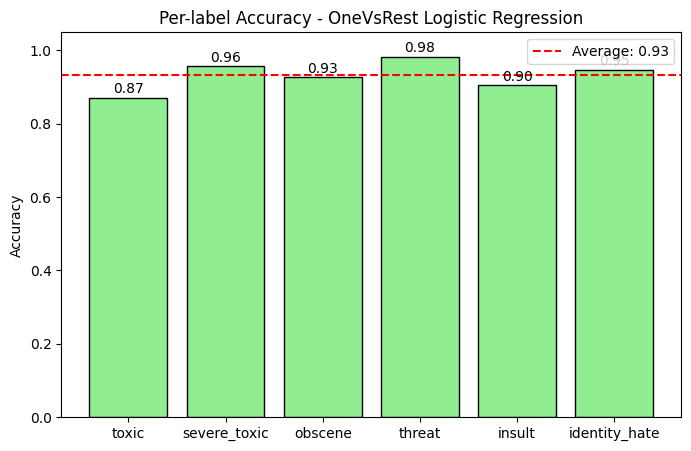

In [ ]:
plt.figure(figsize=(8,5))
bars = plt.bar(labels, per_label_acc, color='lightgreen', edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)

# Optional: horizontal line for average accuracy
avg_acc = np.mean(per_label_acc)
plt.axhline(y=avg_acc, color='red', linestyle='--', label=f'Average: {avg_acc:.2f}')

plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Per-label Accuracy - OneVsRest Logistic Regression')
plt.legend()
if SAVE_PLOTS_AS_IMAGES:
    plt.savefig('img/per_label_acc_vals.png')
plt.show()